<h1><center>Differentiable Hartree-Fock & the H$_2$-molecule </center></h1>
In this notebook, the application of quantum algorithms on the Hartree-Fock approximation for quantum chemistry systems will be discussed. As an explicit example, properties of H$_2$ are calculated with PennyLane.

# 1 Theory
The concept of the Hartee-Fock approximation for many particle systems will briefly be discussed. Atomic and CGS units will be used, i.e. $\hbar=e_0=m_e=4\pi\epsilon_0=1.$

## 1.1 Quantum Chemistry
The physical properties of systems investigated in quantum chemistry (e.g. electrolyte-surface interfaces) are derived from the many body state $|\psi \rangle$, which solves the stationary Schrödinger equation

$$ \hat{H}|\psi \rangle=E |\psi \rangle. $$
In the following, the occupation number representation will be used, i.e.

$$ |\psi \rangle \rightarrow |n_1,n_2,...,n_N \rangle, $$
with fermionic occupation numbers $n_i =0,1$ of particle $i$. Further, we will assume a non degenerate ground state  and thermodynamic equilibrium at $T=0$K.

## 1.2 Differentiable Hartree-Fock
Methods in many particle theory like Hartree-Fock, which is used in the quantum chemistry methods of PennyLane, can smartly be formulated in second quantization, introducing the fermionic ladder operators.
The molecular Hamilton operator in second quantization can be derived as

$$ \hat{H} = \sum_{p,q}h_{p,q}\,a_p\,a^{\dagger}_q \, +\, \frac{1}{2}\sum_{p,q,r,s}h_{p,q,r,s}\,a^{\dagger}_p\,a^{\dagger}_q a_r \,a_s\,, $$
with $a^{\dagger}_q$, $a_q$, $a^{\dagger}_p$, ... being the fermionic ladder operators that act on particle $q,p,r,s$ respectively.<br>
The coefficients $h_{p,q}$ and $h_{p,q,r,s}$ in terms of single particle orbitals $\Phi(\mathbf{r})$ can be written as
$$ h_{p,q}= \int \mathrm{d}^3\mathbf{r}\,\Phi^{\star}_p(\mathbf{r})\left[ -\frac{\nabla^2}{2}- \sum_{i=1}^{N_\mathrm{cores}} \frac{Z_i}{|\mathbf{r}-\mathbf{R_i}|}\right] \Phi_q(\mathbf{r}) ,$$
denoting the $p\rightarrow q$-matrix element of the kinetic energy + the single particle coulomb interaction with the core $i$ with atomic number $Z_i$ and coordinate $\mathbf{R_i},$ and
$$ h_{p,q,r,s} = \int \mathrm{d}^3\mathbf{r_1}\int \mathrm{d}^3\mathbf{r_2} \frac{\Phi^{\star}_p(\mathbf{r_1})\Phi_s(\mathbf{r_1})\Phi^{\star}_q(\mathbf{r_2})\Phi_r(\mathbf{r_2})}{|\mathbf{r_1}-\mathbf{r_2}|}$$
beeing the two electron pair interaction energy at locations $\mathbf{r_1}$ and $\mathbf{r_2}$.


# 2 Implementation
The simulations will be done using **PennyLane** and Python3.9. The code is taken from
[[1]](#another_cell) and [[2]](#another_cell).<br> 
PennyLane simulates a quantum computers hardware, so that quantum algorithms can be run. Predefined methods that realize the Hartree-Fock formalism with quantum algorithms are given. 
## 2.1 Classical Variation
For example, we can define a H$_2$-molecule via the `mol` method, that takes arguments `symbols` and `geometry`. The total energy in Hartree-Fock approximation is calculated via `hf_energy(mol)(geometry)`:

In [14]:
from autograd import grad
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=5)

symbols = ["H", "H"]
# optimized geometry at the Hartree-Fock level
geometry = np.array([[-0.672943967415407, 0.0, 0.0],
                     [ 0.672943967415407, 0.0, 0.0]], requires_grad=True)
mol = qml.qchem.Molecule(symbols, geometry)
a = qml.qchem.hf_energy(mol)(geometry)
print(a)

[-1.11751]


With these predefined methods, we can compute e.g. the bonding length of the H$_2$ molecule by minimizing the total energy $E=\langle\psi(\mathbf{R})|\hat{H} |\psi(\mathbf{R})\rangle$ in terms of the molecular coordinates $\mathbf{R}$:

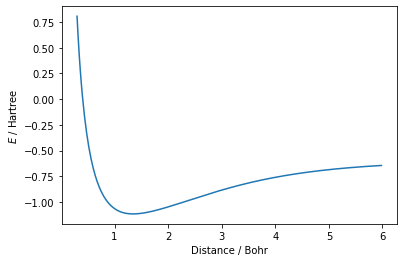

Bonding length = 1.34 Bohr


In [28]:
x=[]
y=[]

for i in range(15,300):
    b = i/100
    geometry = np.array([[b, 0.0, 0.0],
                         [ -1*b, 0.0, 0.0]], requires_grad=True)

    mol = qml.qchem.Molecule(symbols, geometry)
    energy=qml.qchem.hf_energy(mol)(geometry)
    x.append(2*b)
    y.append(energy)

    plt.plot(x,y)
plt.ylabel("$E$ / Hartree")
plt.xlabel("Distance / Bohr")
plt.show()
min=np.argmin(y)
print("Bonding length =",x[min],"Bohr") # approximate bonding length of H_2 in Bohr

This achieves $\approx$ 4% deviation from numerical results using DFT (ref. [[3]](#another_cell)).

With the same principle, the gradient $\nabla E$ in terms of the nuclear coordinates can be displayed via the
`grad()` method. Since in the above example we only varied the nuclear coordinates in the $x$-direction, we compute the gradient only in $\mathbf{R_x}$-direction as well:

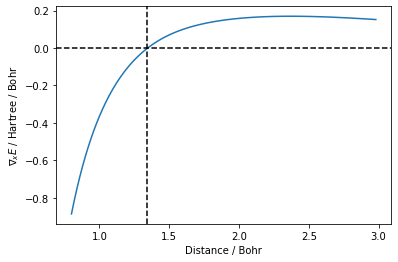

In [39]:
x=[]
y=[]

for i in range(40,150):
    b = i/100
    geometry = np.array([[b, 0.0, 0.0],
                         [ -1*b, 0.0, 0.0]], requires_grad=True)

    mol = qml.qchem.Molecule(symbols, geometry)
    d_energy=grad(qml.qchem.hf_energy(mol))(geometry)
    x.append(2*b)
    y.append(d_energy[0][0])  
plt.plot(x,y)
plt.axhline(y=0,linestyle="--",color="black")
plt.axvline(x=1.34,linestyle="--",color="black")
plt.ylabel(r"$\nabla_xE$ / Hartree / Bohr")
plt.xlabel("Distance / Bohr")
plt.show()

Unsurprisingly, the gradient reaches zero at the prior computed bonding length, as change in energy should be minimal in the region of the equilibrium distance.

## 2.2 VQE Simulations


<a id='another_cell'></a> 
# References 
[1] *Differentiable quantum computational chemistry with
PennyLane*, Juan Miguel Arrazola et al., https://arxiv.org/abs/2111.09967
<br>
    [2] *Differentiable Hartree-Fock*, Website, Soran Jahangiri, https://pennylane.ai/qml/demos/tutorial_differentiable_HF.html <br>
                                                                                                                                    [3] *Describing static correlation in bond dissociation by Kohn–Sham density functional theory*, Martin Fuchs et al, The Journal of chemical physics 122, page 94116

In [ ]:
Implementation